# Fine-tuning InceptionV3 for flowers classification
credits: this workshop adapts materials from MOOC [Advanced Machine Learning](https://www.coursera.org/learn/intro-to-deep-learning/home/welcome) by National Research University Higher School of Economics on Coursera. 

Dataset resource: https://www.kaggle.com/alxmamaev/flowers-recognition

## dataset 

In [1]:
def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """
    
    if img.shape[0] < img.shape[1]:
        # h < w
        mid = img.shape[1] // 2
        cropped_img = img[:,(mid-img.shape[0]//2):(mid+img.shape[0]//2),:]
    else:
        # h > w
        mid = img.shape[0] // 2
        cropped_img = img[(mid-img.shape[1]//2):(mid+img.shape[1]//2),:,:]    
    return cropped_img

IMG_SIZE = 224

In [2]:
from glob import glob
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_path = '../datasets/flowers/*/*.jpg'

data_files = glob(data_path, recursive=True)

In [4]:
flower_classes = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}
flower_classnames = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [5]:
data_files[0].split('/')

['..', 'datasets', 'flowers', 'tulip', '14071516088_b526946e17_n.jpg']

In [6]:
def read_data(data_files, img_size=IMG_SIZE):
    """ 
    Can plugin data augmentation here.
    """
    x_arr = np.zeros((len(data_files), img_size, img_size, 3), dtype=np.int32)
    y_arr = np.zeros((len(data_files)), dtype=np.int32)
    for i, f in enumerate(data_files):
        # obtain flower class
        flower_id = flower_classes[f.split('/')[3]]
        
        # read the file
        flower_img = mpimg.imread(f)
        # center cropping
        flower_img = image_center_crop(flower_img)
        # resize
        flower_img = cv2.resize(flower_img, (img_size, img_size))
        
        x_arr[i] = flower_img
        y_arr[i] = flower_id
    assert len(x_arr) == len(y_arr)
    return x_arr, y_arr

In [7]:
images, labels = read_data(data_files)

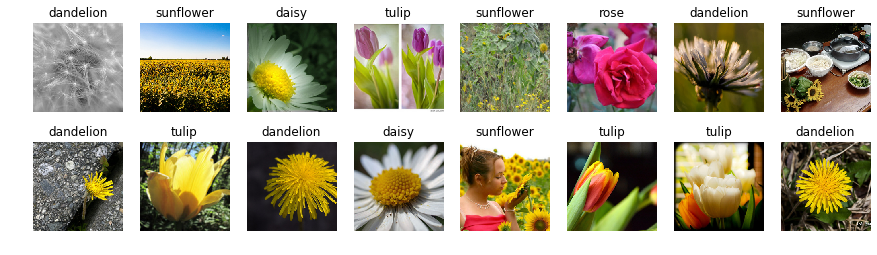

In [8]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(images[random_index, :])
        ax.set_title(flower_classnames[labels[random_index]])
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, shuffle=True)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, shuffle=True)

Using TensorFlow backend.


In [10]:
# normalizing
x_train = train_images / 255 - 0.5
x_val = val_images / 255 - 0.5
x_test = test_images / 255 - 0.5

y_train = to_categorical(train_labels)
y_val = to_categorical(val_labels)

In [11]:
print('training samples:', x_train.shape, y_train.shape)
print('validation samples:', x_val.shape, y_val.shape)
print('test samples:', x_test.shape, test_labels.shape)

training samples: (2766, 224, 224, 3) (2766, 5)
validation samples: (692, 224, 224, 3) (692, 5)
test samples: (865, 224, 224, 3) (865,)


In [12]:
# import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
import keras

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.visible_device_list = "4"
set_session(tf.Session(config=config))



In [13]:
from keras.callbacks import ModelCheckpoint

In [14]:
IMG_SIZE = 224
N_CLASSES = 5

In [15]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [16]:
model = inception()

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [18]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [19]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [20]:
epochs = 5
batch_size = 128
model_filename = 'flower.h5'
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often
training = model.fit(x_train, y_train, 
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_val, y_val), 
          callbacks=[ModelCheckpoint(model_filename, save_best_only=True)],
          verbose=1)

Train on 2766 samples, validate on 692 samples
Epoch 1/3
2766/2766 [==============================] - 30s 11ms/step - loss: 0.6357 - acc: 0.7983 - val_loss: 0.5142 - val_acc: 0.8555
Epoch 2/3
2766/2766 [==============================] - 14s 5ms/step - loss: 0.1606 - acc: 0.9512 - val_loss: 0.3139 - val_acc: 0.8974
Epoch 3/3
2766/2766 [==============================] - 13s 5ms/step - loss: 0.0572 - acc: 0.9866 - val_loss: 0.2990 - val_acc: 0.9003


In [22]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

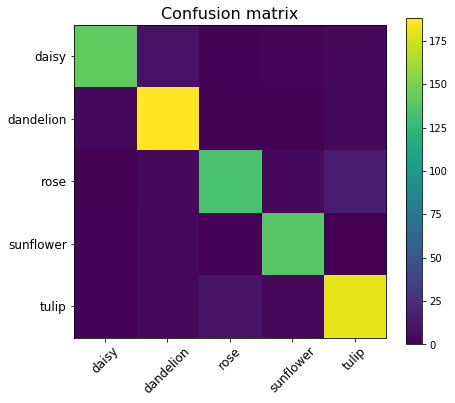

Test accuracy: 0.9063583815028902


In [24]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(test_labels, y_pred_test_classes))
plt.xticks(np.arange(N_CLASSES), flower_classnames, rotation=45, fontsize=12)
plt.yticks(np.arange(N_CLASSES), flower_classnames, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(test_labels, y_pred_test_classes))